# Assignment 

In this assignment, we will design a regression model by using the [House Prices](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data) dataset from Kaggle. This dataset consists of 79 variables describing many aspects of residential homes in Ames, Iowa. 

We will familiarize ourselves with the data by performing EDA to identify trends, spot anaomiles, select features, and more. Once this stage is complete, we will split our data into train and test sets where 20% of the data resides in the test set. Then, we will build several linear regression models including Lasso, Ridge, or ElasticNet and train them in the training set. We will also use k-fold cross-validation to select the best hyperparameters for our models. Once we evaluate our best model on the test set, we will introduce addition factors that may affect house prices. 


In [1]:
# Numpy and pandas
import pandas as pd
import numpy as np

#Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

# Statistics tools
import scipy.stats as stats

# Model prep and Modeling 
from sklearn.decomposition import PCA 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV

# Evaluate
from sklearn.metrics import mean_absolute_error
import statsmodels.api as sm
from statsmodels.tools.eval_measures import mse, rmse

# Import data
from sqlalchemy import create_engine
import warnings

warnings.filterwarnings('ignore')

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'houseprices'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

houseprices_df = pd.read_sql_query('select * from houseprices',con=engine)

# no need for an open connection, 
# as we're only doing a single query
engine.dispose()

## Data Cleaning and Formatting 

### Load in the Data  and Examine

First, we will create a copy of the original house price dataframe so that we can manipulate and clean the data without disturbing the original dataset. We will begin by loading the data and format the column names by stripping spaces and convert to lowercase. 

In [2]:
# Rename columns that contain trailing spaces

df = houseprices_df.copy()

df.columns = df.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('__', '_').str.replace('(', '').str.replace(')', '')

print(df.shape)

df.head()

(1460, 81)


,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
0,1,60,RL,65.0,8450,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,None,Reg,Lvl,AllPub,...,0,None,None,None,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,12,2008,WD,Normal,250000


In [3]:
# Datatypes 

df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
id               1460 non-null int64
mssubclass       1460 non-null int64
mszoning         1460 non-null object
lotfrontage      1201 non-null float64
lotarea          1460 non-null int64
street           1460 non-null object
alley            91 non-null object
lotshape         1460 non-null object
landcontour      1460 non-null object
utilities        1460 non-null object
lotconfig        1460 non-null object
landslope        1460 non-null object
neighborhood     1460 non-null object
condition1       1460 non-null object
condition2       1460 non-null object
bldgtype         1460 non-null object
housestyle       1460 non-null object
overallqual      1460 non-null int64
overallcond      1460 non-null int64
yearbuilt        1460 non-null int64
yearremodadd     1460 non-null int64
roofstyle        1460 non-null object
roofmatl         1460 non-null object
exterior1st      1460 non-n

There are 81 attributes and 1,460 rows in this dataset. Currently, there are 43 categorical and 38 continous varibles describing aspects of houses sold in Ames, Iowa. There are a couple of date columns and an id column that were entered as integers. Since the focus of this assignment is predicting sale price and not working with a time series dataset, we will convert the columns to strings. 

In [4]:
# Convert to string 

convert_type = ['id','yearbuilt','yearremodadd','garageyrblt','mosold','yrsold']

df[convert_type] = df[convert_type].astype(str)

In [5]:
num_var = df.select_dtypes(['int64', 'float64']).columns
print('There are {} numeric varibles'.format(len(num_var)))

cat_var = df.select_dtypes(['object']).columns
print('There are {} categorical varibles'.format(len(cat_var)))

There are 32 numeric varibles
There are 49 categorical varibles


After converting columns to the correct types, we now have 33 numeric and 48 categorical variables. 

Let's get a basic description of the dataset by viewing summary statistics.

In [6]:
# Dataframe statistics 

df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,70.049958,10516.828082,6.099315,5.575342,103.685262,443.639726,46.549315,567.240411,1057.429452,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,42.300571,24.284752,9981.264932,1.382997,1.112799,181.066207,456.098091,161.319273,441.866955,438.705324,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,59.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,69.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,70.000000,80.000000,11601.500000,7.000000,6.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


In [7]:
df.describe(include=['object'])

,id,mszoning,street,alley,lotshape,landcontour,utilities,lotconfig,landslope,neighborhood,...,garagequal,garagecond,paveddrive,poolqc,fence,miscfeature,mosold,yrsold,saletype,salecondition
count,1460,1460,1460,91,1460,1460,1460,1460,1460,1460,...,1379,1379,1460,7,281,54,1460,1460,1460,1460
unique,1460,5,2,2,4,4,2,5,3,25,...,5,5,3,3,4,4,12,5,9,6
top,692,RL,Pave,Grvl,Reg,Lvl,AllPub,Inside,Gtl,NAmes,...,TA,TA,Y,Gd,MnPrv,Shed,6,2009,WD,Normal
freq,1,1151,1454,50,925,1311,1459,1052,1382,225,...,1311,1326,1340,3,157,49,253,338,1267,1198


Here are some initial observations:
 - Lot area varies drastically from 1,300 square feet (2 bedroom) to 215,245 square feet (mega-mansion).
 - The average house has a basement of 1,057 square feet. 
 - Majority of garages can store up to 2 cars.
 - The average pool area is around 2 square feet, which indicates that these houses probably do not have a pool. This may be typical of a house in Iowa. 
 - The sale prices ranges from \\$34,900 to \\$755,000. The average price for a house was around \$180,921. 
  
 - These houses were built from 1872 to 2010. The average house in this dataset was built around 1971.
 - Houses in Northern Ames neighborhood were sold the most. 
 - The data captures houses sold from 2006 to 2010. Summer months, particularly June 2009 was the most popular buying season.


### Missing Values 
After correcting column data types, let's take a look at missing data. Questions that we should keep in mind include how prevalent is missing data and if these values are missing at random. Answering these questions will help us detect potential bias in data collection and uncover truths. 

In [8]:
# Function to calculate missing values by column
def missing_values_table(df):
        # Total missing values
        mis_val = df.isnull().sum()
        
        # Percentage of missing values
        mis_val_percent = 100 * df.isnull().sum() / len(df)
        
        # Make a table with the results
        mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
        
        # Rename the columns
        mis_val_table_ren_columns = mis_val_table.rename(
        columns = {0 : 'Missing Values', 1 : '% of Total Values'})
        
        # Sort the table by percentage of missing descending
        mis_val_table_ren_columns = mis_val_table_ren_columns[
            mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
        '% of Total Values', ascending=False).round(1)
        
        # Print some summary information
        print ("Your selected dataframe has " + str(df.shape[1]) + " columns.\n"      
            "There are " + str(mis_val_table_ren_columns.shape[0]) +
              " columns that have missing values.")
        
        # Return the dataframe with missing information
        return mis_val_table_ren_columns

In [9]:
missing_values_table(df)

Your selected dataframe has 81 columns.
There are 18 columns that have missing values.


,Missing Values,% of Total Values
poolqc,1453,99.5
miscfeature,1406,96.3
alley,1369,93.8
fence,1179,80.8
fireplacequ,690,47.3
lotfrontage,259,17.7
garagetype,81,5.5
garagefinish,81,5.5
garagequal,81,5.5
garagecond,81,5.5


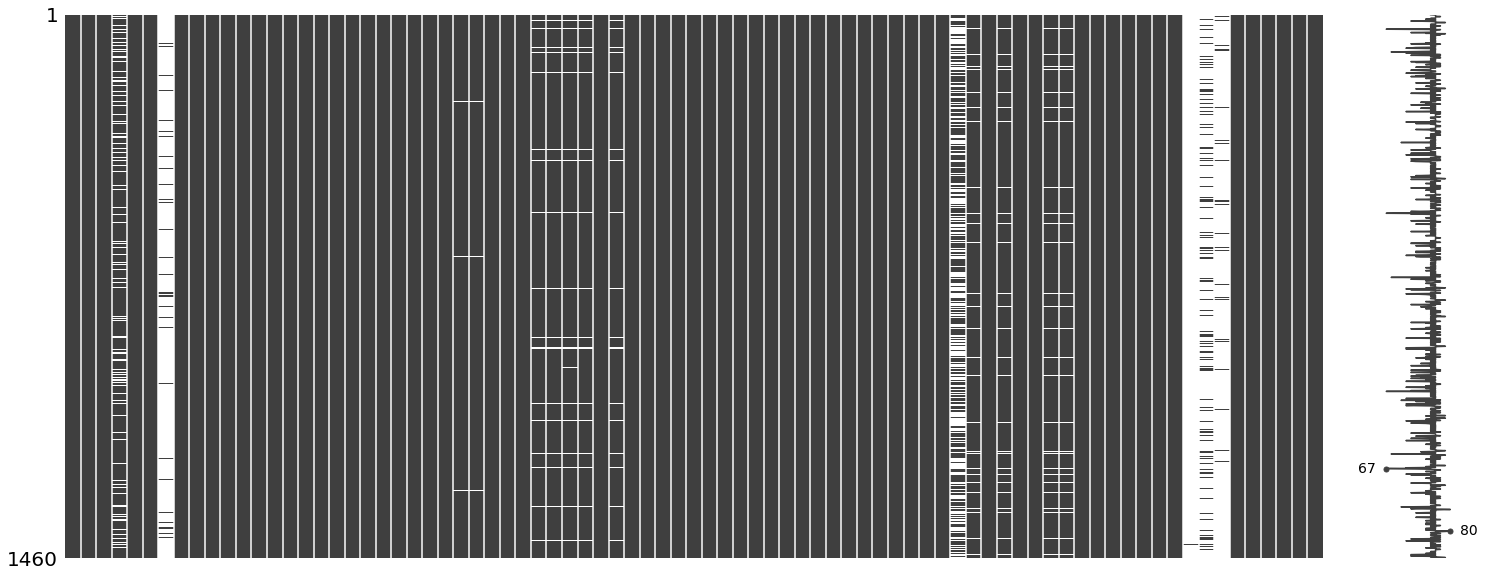

In [10]:
# Create nullity matrix for missing values 

msno.matrix(df)

We can observe that the top 5 variables in the table are missing more than 40% of datapoints. Since these are categorical data, we'll replace NA values with none.  With the remaining variables, we can impute missing values with their respective mode. 


In [11]:
# Get columns with >= 40% missing

missing_df = missing_values_table(df)
missing_columns = list(missing_df[missing_df['% of Total Values'] >= 40].index)
print('We will impute %d columns.' % len(missing_columns))

Your selected dataframe has 81 columns.
There are 18 columns that have missing values.
We will impute 5 columns.


In [12]:
# Repalce NA with None

df[missing_columns] = df[missing_columns].fillna('None')

Now, we will fill remaining missing values with the mode. 

In [13]:
# Imputation by mode

df = df.fillna(df.mode().iloc[0])

Let's check to see whether the null values were missing at random by comparing descriptive statistics before and after dropping the values. 

In [14]:
# Check to see remaining null values 

missing_values_table(df)

Your selected dataframe has 81 columns.
There are 0 columns that have missing values.


,Missing Values,% of Total Values


In [15]:
# Dataset before drop values 

houseprices_df.describe()

,id,mssubclass,lotfrontage,lotarea,overallqual,overallcond,yearbuilt,yearremodadd,masvnrarea,bsmtfinsf1,...,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,mosold,yrsold,saleprice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [16]:
# Dataset after drop values 
df.describe()

,mssubclass,lotfrontage,lotarea,overallqual,overallcond,masvnrarea,bsmtfinsf1,bsmtfinsf2,bsmtunfsf,totalbsmtsf,...,garagecars,garagearea,wooddecksf,openporchsf,enclosedporch,threessnporch,screenporch,poolarea,miscval,saleprice
count,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,56.897260,68.267123,10516.828082,6.099315,5.575342,103.117123,443.639726,46.549315,567.240411,1057.429452,...,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,180921.195890
std,42.300571,22.356355,9981.264932,1.382997,1.112799,180.731373,456.098091,161.319273,441.866955,438.705324,...,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,79442.502883
min,20.000000,21.000000,1300.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,34900.000000
25%,20.000000,60.000000,7553.500000,5.000000,5.000000,0.000000,0.000000,0.000000,223.000000,795.750000,...,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,129975.000000
50%,50.000000,63.000000,9478.500000,6.000000,5.000000,0.000000,383.500000,0.000000,477.500000,991.500000,...,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,163000.000000
75%,70.000000,79.000000,11601.500000,7.000000,6.000000,164.250000,712.250000,0.000000,808.000000,1298.250000,...,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,214000.000000
max,190.000000,313.000000,215245.000000,10.000000,9.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,...,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,755000.000000


There doesn't appear to be a drastic change in the means after dropping the null values so we will assume that the data was completely missing at random. 
  

## Exploring Data 

Now that we have "cleaned" the data, we can begin exploratory data analysis. EDA is an iterative process to explore the data and summarize characteristics by calculating statistics or visualize methods.  The purpose of EDA is gain an understanding of the data by identifying trends, anomalies, or relationships that might be helpful when making decisions in the modeling process. We can starts out with a high-level overview. If we find an interesting trend, then we can narrow in our focus.



### Univariate Analysis 

We will begin EDA by exploring individual variables, particularly sale price since it is our target variable. 

Text(0.5, 1.0, 'Sale Price')

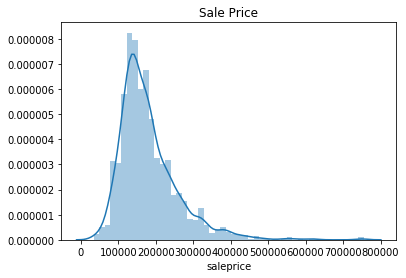

In [17]:
# Plot sale price 

sns.distplot(df.saleprice)
plt.title('Sale Price')

We can observe that the distribution of sale price is heavely skewed to the right. Let's look at some statistics for this feature. 

In [18]:
df['saleprice'].describe()


count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [19]:
print("Skewness: %f" % df['saleprice'].skew())
print("Kurtosis: %f" % df['saleprice'].kurt())

Skewness: 1.882876
Kurtosis: 6.536282


The statistics offers insight on the central tendencies of the distribution. The average house in Ames, Iowa sold for \\$180,921 while the median of the distribution is around \\$163,300. That there is also a large price gap between 75% of house prices being listed under \\$214,000 and the maximum value of \\$755,000. A __skewness__ of 1.88 confirms that sale price not normally distributed and is right skewed. A __kurtosis__ of 6.54 indicates a heavy tail distribution that is not symmetrical. We will transform the data to treat skewness later. 

Below are the returned rows for house prices that were more than \\$700,000. These data points will probably be extreme outliers in our dataset. For now, we will keep them aside, but may consider dropping them to increase our accuracy percentage when trying to improve our model's performance.



In [20]:
df.loc[df['saleprice']>=700000]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


### Removing Outliers

Although outliers contain meaningful information, linear regression machine learning models are sensitive to extreme values so we will exclude extreme values. However, if we were to remove all outliers from the training set, our model will not perform well when handling outliers in the testing set. To reach a compromise, we will set the threshold at 3 standard deviations as it will allow us to retain 99% of the dataset. Then, we will replace the extreme values with the threshold since they are close in value.

In [21]:
# Function to detect extreme values and replace with threshold value

def outlier_table(df):
    for column in df.select_dtypes(['int64', 'float64']).columns:
        if df[column].quantile(.9973)<df[column].max():
            threshold = df[column].quantile(.9973)
            df[column] = np.where(df[column] > threshold, int(round(threshold)),df[column])
            if df[column].quantile(0)>df[column].min():
                threshold = df[column].min()
                df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        
        elif df[column].quantile(0)>df[column].min():
            threshold = df[column].min()
            df[column] = np.where(df[column] < threshold, int(round(threshold)),df[column])
        else:
            pass
    return df
            

In [22]:
# Create df2 with extreme values removed 
df2 = df.copy()

# remove sale price column 
df2 = df2.drop(['saleprice'],axis=1) 
df2 = outlier_table(df2)

# adding sale price after removing outliers form other columns 
# we'll take the natural log of sale price later 
df2['saleprice'] = df['saleprice'] 

Let's check if the function works by seeing if the extreme values in sale prices were converted to the 99% threshold value of \\$584,676.

In [23]:
# Before removing extreme values

df.loc[df['saleprice']>=584676]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
898,899,20,RL,100.0,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,555,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


In [24]:
# After removing extreme values 

df2.loc[df2['saleprice']>=584676]

,id,mssubclass,mszoning,lotfrontage,lotarea,street,alley,lotshape,landcontour,utilities,...,poolarea,poolqc,fence,miscfeature,miscval,mosold,yrsold,saletype,salecondition,saleprice
691,692,60,RL,104.0,21535,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,1,2007,WD,Normal,755000
898,899,20,RL,100.0,12919,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,3,2010,New,Partial,611657
1169,1170,60,RL,118.0,35760,Pave,None,IR1,Lvl,AllPub,...,0,None,None,None,0,7,2006,WD,Normal,625000
1182,1183,60,RL,160.0,15623,Pave,None,IR1,Lvl,AllPub,...,521,Ex,MnPrv,None,0,7,2007,WD,Abnorml,745000


Looks like the function worked! Let's continue exploring the remaining variables. 

### Multivariable Analysis

As previously mentioned in the primary stage of loading the data, this dataset contains two types of features, numeric and categorical. 

__Numerical variables__ are data in numeric form such as integers and floats. Numeric values can be classified into discrete and continuous variables. Discrete numerical variables are whole number values such as the number of rooms in a house. Meanwhile continuous numerical variables may contain any value within some range like sale prices of houses. 

__Categorical variables__ are essentially small groups of categories. Categorical variables can be further categorized into ordinal and nominal variables. Ordinal categorical variables have meaningful order such as a scale of overall quality finish of a house. In contrast, nominal categorical variables purely assign data to groups without intrinsic ordering. We have variables of this type in our dataset such as sale condition, land contour, and zoning classification. 
 

In [25]:
# Numeric variables 

df2.select_dtypes(['int64', 'float64']).columns

Index(['mssubclass', 'lotfrontage', 'lotarea', 'overallqual', 'overallcond',
       'masvnrarea', 'bsmtfinsf1', 'bsmtfinsf2', 'bsmtunfsf', 'totalbsmtsf',
       'firstflrsf', 'secondflrsf', 'lowqualfinsf', 'grlivarea',
       'bsmtfullbath', 'bsmthalfbath', 'fullbath', 'halfbath', 'bedroomabvgr',
       'kitchenabvgr', 'totrmsabvgrd', 'fireplaces', 'garagecars',
       'garagearea', 'wooddecksf', 'openporchsf', 'enclosedporch',
       'threessnporch', 'screenporch', 'poolarea', 'miscval', 'saleprice'],
      dtype='object')

In [26]:
# Categorical variables 

df2.select_dtypes(['object']).columns

Index(['id', 'mszoning', 'street', 'alley', 'lotshape', 'landcontour',
       'utilities', 'lotconfig', 'landslope', 'neighborhood', 'condition1',
       'condition2', 'bldgtype', 'housestyle', 'yearbuilt', 'yearremodadd',
       'roofstyle', 'roofmatl', 'exterior1st', 'exterior2nd', 'masvnrtype',
       'exterqual', 'extercond', 'foundation', 'bsmtqual', 'bsmtcond',
       'bsmtexposure', 'bsmtfintype1', 'bsmtfintype2', 'heating', 'heatingqc',
       'centralair', 'electrical', 'kitchenqual', 'functional', 'fireplacequ',
       'garagetype', 'garageyrblt', 'garagefinish', 'garagequal', 'garagecond',
       'paveddrive', 'poolqc', 'fence', 'miscfeature', 'mosold', 'yrsold',
       'saletype', 'salecondition'],
      dtype='object')

### Looking for Relationships

To determine which explanatory variables we might select for our prediction model, we will explore the correlation between sale price and other variables. __Correlation__ refers to a mutal association between variables. Variables that have a strong correlation, whether it being positive or negative, will affect the target variable. 



#### Numeric Variables

First, we'll take a look at the correlation between sale price and numeric variables.

In [27]:
# Correlation between sale price and numeric variables 

corrmat = df2.corr()
print(corrmat['saleprice'].sort_values(ascending = False),'\n')

saleprice        1.000000
overallqual      0.790982
grlivarea        0.718394
garagecars       0.640409
totalbsmtsf      0.640195
garagearea       0.627388
firstflrsf       0.624533
fullbath         0.560664
totrmsabvgrd     0.535324
masvnrarea       0.474059
fireplaces       0.466929
bsmtfinsf1       0.402366
lotfrontage      0.351627
lotarea          0.342989
wooddecksf       0.324950
openporchsf      0.322656
secondflrsf      0.311295
halfbath         0.284108
bsmtfullbath     0.228364
bsmtunfsf        0.213071
bedroomabvgr     0.169257
screenporch      0.110348
poolarea         0.095084
threessnporch    0.050006
bsmtfinsf2      -0.014274
bsmthalfbath    -0.015957
lowqualfinsf    -0.028883
miscval         -0.034383
overallcond     -0.077856
mssubclass      -0.084284
enclosedporch   -0.135038
kitchenabvgr    -0.136018
Name: saleprice, dtype: float64 



The most correlated variables to sale price:
 - overallqual: overall material and finish quality
 - grlivarea: above grade (ground) living area square feet
 - garagecars: size of garage in car capacity
 - garagearea: size of garage in square feet
 - totalbsmtsf: total square feet of basement area
 - firstflrsf: first floor square feet
 - fullbath: full bathrooms above grade 
 - totrmsabvgrd: total rooms above grade (does not include bathrooms)

These results make sense since buyers would be interested in knowing the general living space, quality of the house, and garage capacity.  

Let's see how each variable relates to sale price.

Text(0.5, 1.0, 'Sale Price vs. Overall Quality without outliers')

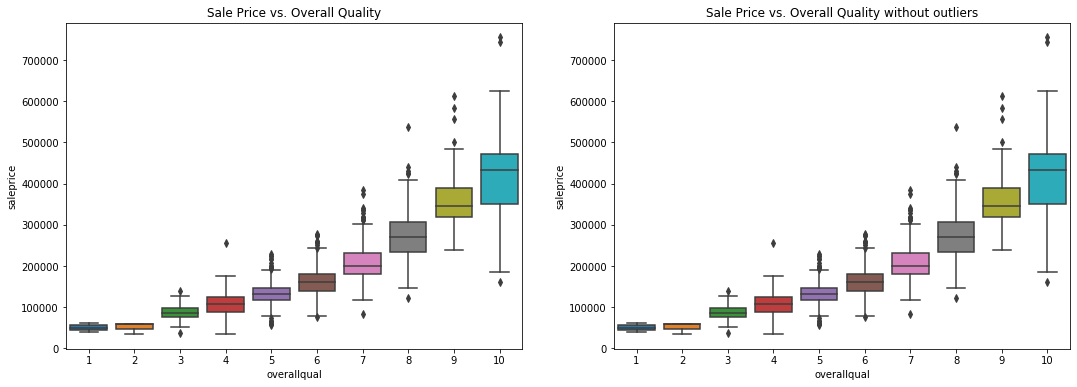

In [28]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='overallqual', y="saleprice", data=df)
plt.title('Sale Price vs. Overall Quality')

plt.subplot(1,2,2)
sns.boxplot(x='overallqual', y="saleprice", data=df2)
plt.title('Sale Price vs. Overall Quality without outliers')

As one would expect, there is a positive association between overall quality and sale price. As the quality of an item increases, the price will follow in the same direction. We can also see that some extreme values beyond the upper quartile in overall quality score of 10 were removed. 

Text(0.5, 1.0, 'Sale Price vs. Above Grade Living Area (SF) without outliers')

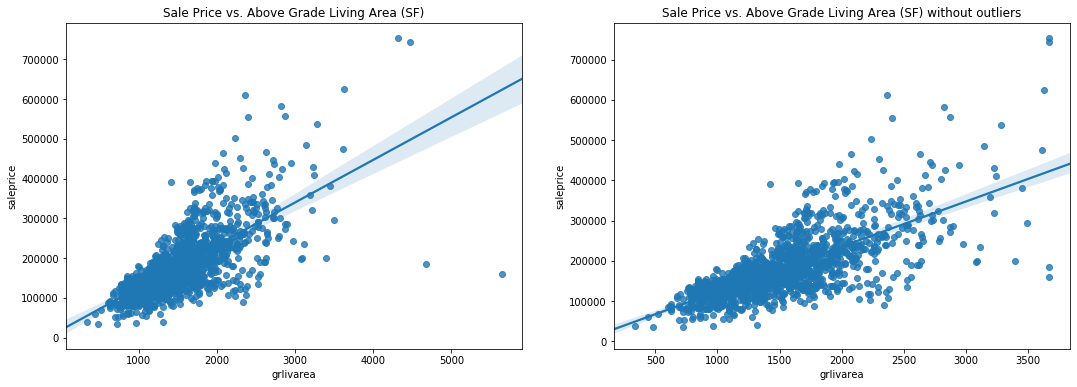

In [29]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="grlivarea", y="saleprice", data=df)
plt.title('Sale Price vs. Above Grade Living Area (SF)')

plt.subplot(1,2,2)
sns.regplot(x="grlivarea", y="saleprice", data=df2)
plt.title('Sale Price vs. Above Grade Living Area (SF) without outliers')

This plot implies that is a positive correlation between the increase of above grade living area and sale price. This is plausible since larger houses will cost more. In the original dataset on the left, there two data points in the lower right corner that appears to be outliers. Houses with living areas more than 4,000 square feet should cost more than houses with smaller living areas. These datapoints were imputed in the right plot. 

Text(0.5, 1.0, 'Sale Price vs. Garage Cars without outliers')

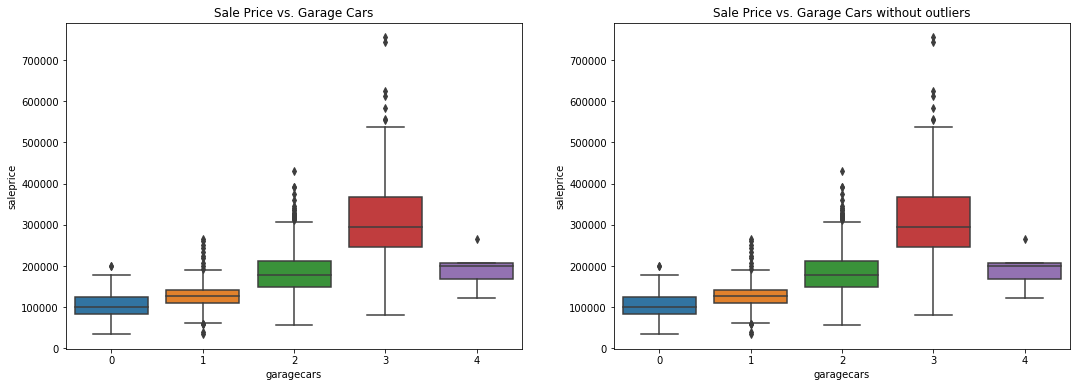

In [30]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='garagecars', y="saleprice", data=df)
plt.title('Sale Price vs. Garage Cars')

plt.subplot(1,2,2)
sns.boxplot(x='garagecars', y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Cars without outliers')

There appears to be a price increase from zero to three garage cars and then the price suddenly drops at four garage cars. This seems a bit suspicious, but our outlier function didn't dectect those data points as extreme values so we'll leave it at that. 

Text(0.5, 1.0, 'Sale Price vs. Garage Area without outliers')

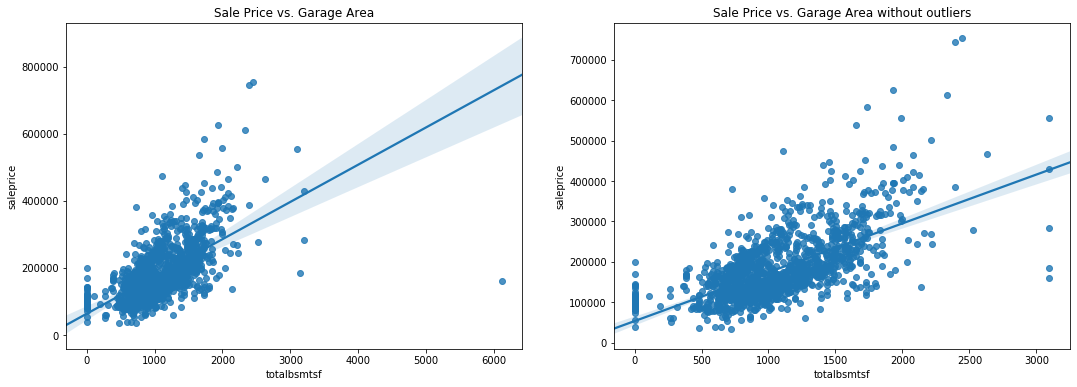

In [31]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="totalbsmtsf", y="saleprice", data=df)
plt.title('Sale Price vs. Garage Area')

plt.subplot(1,2,2)
sns.regplot(x="totalbsmtsf", y="saleprice", data=df2)
plt.title('Sale Price vs. Garage Area without outliers')

Similar to above grade living area, we also see a data points at the lower right corner of this plot. As garage area increase, the price should also increase. The second plot did treat that datapoint. The confidence level on the right plot also greatly reduced from the left plot noting that the extreme value did have a large effect on the data.

Text(0.5, 1.0, 'Sale Price vs. Total square feet of Basement area without outliers')

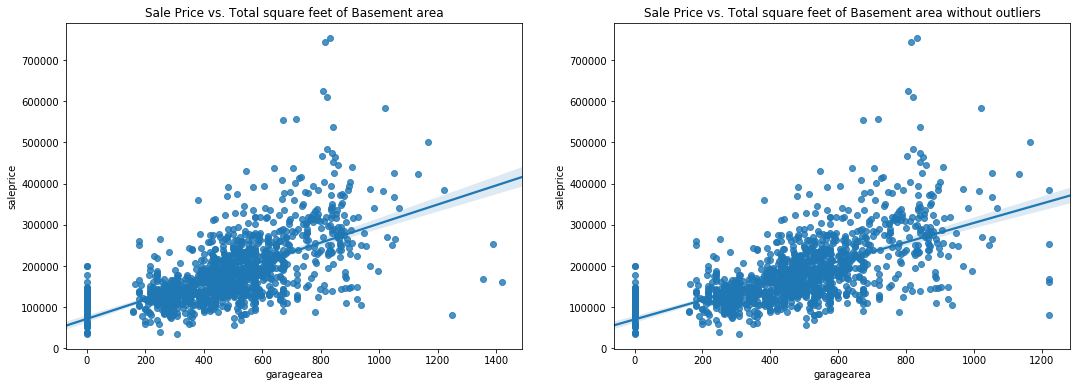

In [32]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="garagearea", y="saleprice", data=df)
plt.title('Sale Price vs. Total square feet of Basement area')

plt.subplot(1,2,2)
sns.regplot(x="garagearea", y="saleprice", data=df2)
plt.title('Sale Price vs. Total square feet of Basement area without outliers')

Again, there a couple of datapoints on the lower right corner that appear to be extreme values. A house with a garage areas more than 1,200 square feet should cost more than \\$100,000.

Text(0.5, 1.0, 'Sale Price vs. First Floor Area (SF) without outliers')

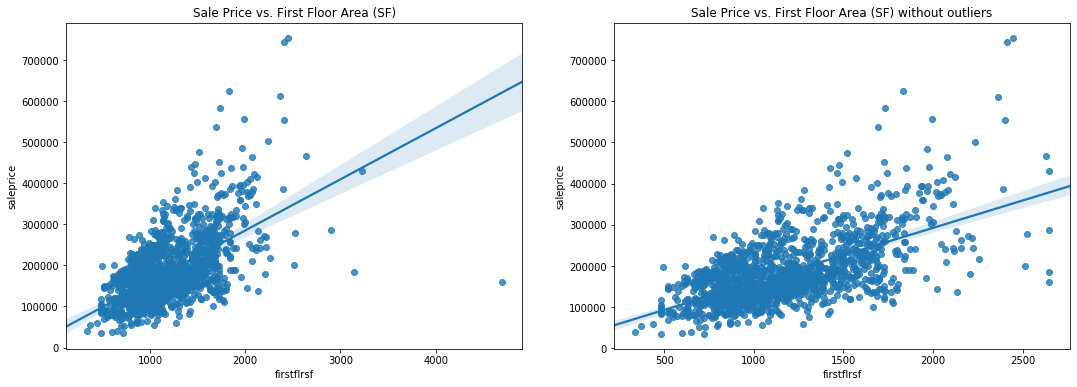

In [33]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.regplot(x="firstflrsf", y="saleprice", data=df)
plt.title('Sale Price vs. First Floor Area (SF)')

plt.subplot(1,2,2)
sns.regplot(x="firstflrsf", y="saleprice", data=df2)
plt.title('Sale Price vs. First Floor Area (SF) without outliers')

Here, we can see two extreme values on the lower right corner and middle top area of the left plot. These values caused the confidence interval to increase as we across the x-axis. Redistributing these values in the right plot lowered the confidence interval. 

Text(0.5, 1.0, 'Sale Price vs. Full Bathrooms without outliers')

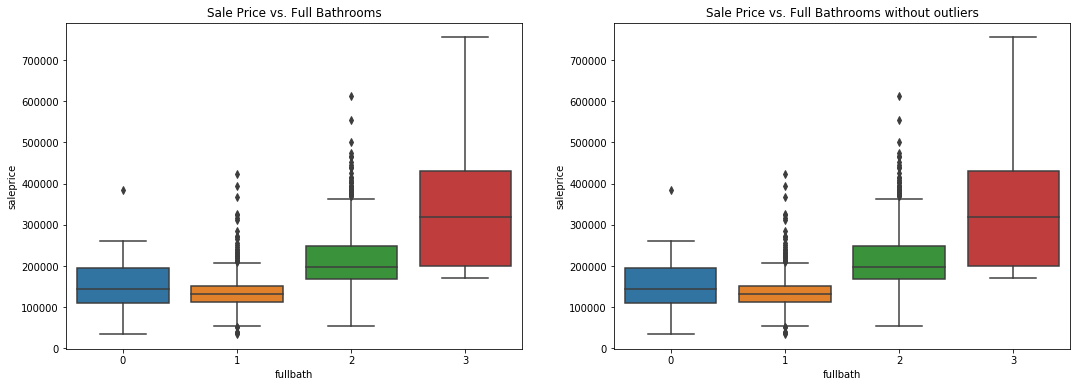

In [34]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='fullbath', y="saleprice", data=df)
plt.title('Sale Price vs. Full Bathrooms')

plt.subplot(1,2,2)
sns.boxplot(x='fullbath', y="saleprice", data=df2)
plt.title('Sale Price vs. Full Bathrooms without outliers')

The average price of a house with zero full bathrooms is higher than a house with one full bathroom. This maybe due to missing data for full baths. 

Text(0.5, 1.0, 'Sale Price vs. Total Rooms above grade without outliers')

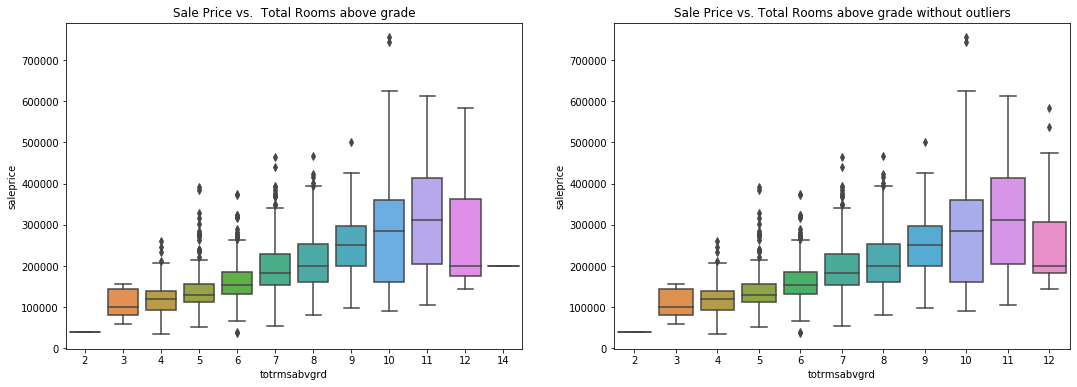

In [35]:
plt.figure(figsize=(18,6))

plt.subplot(1,2,1)
sns.boxplot(x='totrmsabvgrd', y="saleprice", data=df)
plt.title('Sale Price vs.  Total Rooms above grade')

plt.subplot(1,2,2)
sns.boxplot(x='totrmsabvgrd', y="saleprice", data=df2)
plt.title('Sale Price vs. Total Rooms above grade without outliers')

As one would assume, the plots describe a positive association between sale price and the total numbers of rooms above ground. Due to the size, houses with more rooms will probably cost more.

#### Categorical Variables 

Finally, we'll be looking at the effects of categorical variables on sale price. We can visualize this interaction by making density plots to show the distribution of the variable. 

Neighborhoods and age of the homes are important factors that house buyers look for. The first plot we will make will show the distribution of sale price by neighborhoods. 

Text(0.5, 1.0, 'Density Plot of Sale Price by Neighborhood')

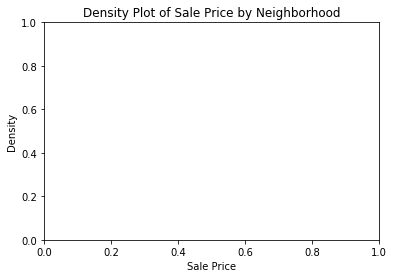

In [36]:
# That didn't work. We'll revisit. 
neigh = df2['neighborhood'].value_counts()

# Plot each neighborhood
for n in neigh:
    subset = df2[df2['neighborhood'] == n]
    
    # Density plot of sale price
    sns.kdeplot (subset['saleprice'],
    label = n, shade = False)
    
plt.xlabel('Sale Price'); plt.ylabel('Density')
plt.title('Density Plot of Sale Price by Neighborhood')

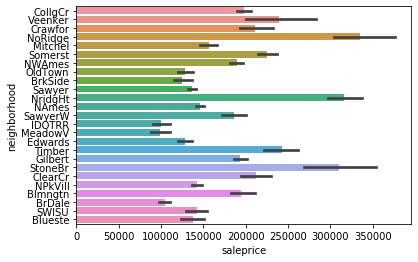

In [37]:
# Failed at trying to sort by sale price
neighborhood = df2.copy()
#neighborhood = neighborhood.groupby('neighborhood')
#neighborhood.apply(lambda x: x.sort_values(by=['saleprice']))
sns.barplot(data=neighborhood, x='saleprice', y='neighborhood')

In [55]:
sns.distplot(df=df2)

TypeError: distplot() got an unexpected keyword argument 'df'

One would expect houses in ares that are highly rated for in safety, near good schools or close to employment opportunties to be in the higher price range. I'm not sure about how these top neighborhoods compare. I can a trend of houses with 3 plue rooms in Northridge, Northpark Villa, and Stone Brook, which would probably cause them to be priced high. 

Before plotting year built, we will create house age groups. 

In [56]:
df2['yearremodadd'] = pd.to_numeric(df['yearremodadd'])
df2['saleprice'] = pd.to_numeric(df['saleprice'])
#df2.yearbuilt.describe()
df2.saleprice.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: saleprice, dtype: float64

In [39]:
# Create new house age groups 

#bins = [0, 5, 10, 20, 30, 40, 50, 60]
#names = ['<5', '5-10', '10-20', '20-30', '30-40', '40-50','50-60', '60+']
#d = dict(enumerate(names, 1))

#df2['houseage'] = np.vectorized(d.get)(np.digitize(df['yearbuilt'], bins))

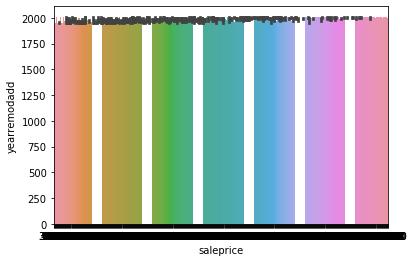

In [57]:
sns.barplot(data = df2, y='yearremodadd',x='saleprice')

## Feature Engineering and Selection

Since we have identified trends and relationship within the dataset, we will out findings to select a set of features for our model. We have learned which numeric values are correlated to sale price. We also have seen the distribution relationship between the sale price and two categorical variables, neighborhoods and year remodeled. 

Before continuing, let's define what feature engineering and selection is. __Feature engineering__ is the process of taking raw data and creating a new feature for the model to map between features and the target. This may involve transforming variables, such as taking the log or one-hot encoding categorical variables. Meanwhile __feature selection__ can be viewed as choosing the most relevant features to the target variable. This could be selecting the highest correlated to target or features with the most variance. Often, these two processes will overlap. 

For this assignment, we will take the following steps for feature engineering:
 * select a few numerical variables and two categorical variables
 * log transformation of sale price
 * one-hot encode for categorical variables
 * creating new variables 
 
We wil do the following for feature selection:
 * remove collinear features 

#### Feature 1: Numeric values 

These are the features that are most correlated to sale price. We will use a heatmap to check for highly __collinear__ features. Collinerity occurs when two or more explanatory variables are highly correlated. This becomes problematic for modeling to estimate the relationship between each explanatory variable and the target variable. 

In [41]:
# Most correlated features 

most_corr = df2.loc[:,['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf',
                    'firstflrsf','fullbath','totrmsabvgrd','saleprice']]


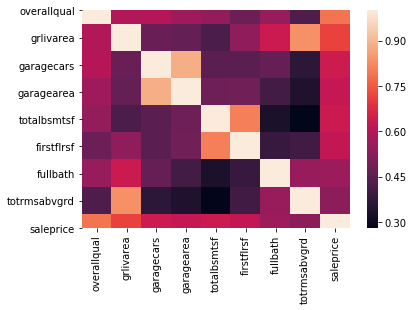

In [42]:
# Heatmap of most correlated variables 

corrmat = most_corr.corr()
sns.heatmap(corrmat)

The variables look relatively independent to each other. We can look at these variables after discovering their coefficent significance when running OLS model.

#### Feature 2: Dummy Variables 
We will be introducing the following categorical variables to the model: neighborhood and year remodel added.

In [58]:
df2 = pd.concat([df2,pd.get_dummies(df2.mszoning, prefix="neighborhood", drop_first=True)], axis=1)
df2 = pd.concat([df2,pd.get_dummies(df2.housestyle, prefix="yearremodadd", drop_first=True)], axis=1)


dummy_column_names = list(pd.get_dummies(df2.mszoning, prefix="neighborhood", drop_first=True).columns)
dummy_column_names = dummy_column_names + list(pd.get_dummies(df2.housestyle, prefix="yearremodadd", drop_first=True).columns)

#### Feature 3: Log transformation 

To increase the fit of our model, we will perform log transformation on sale price since it is highly skewed to the right. 

#### Feature 4: New variables 

We'll also introduce a new variable by combining total basement area, first, and second floor area as total square feet. Lastly, we will add the interaction between total square feet and overall quality of the house.

In [59]:
# Create new variables 
df2['totalsf'] = df2['totalbsmtsf'] + df2['firstflrsf'] + df2['secondflrsf']

df2['int_over_sf'] = df2['totalsf'] * df2['overallqual']

### Split into Training and Testing Sets
In machine learning, we will need to separate our features into two sets, training and testing. __Training set__ is used to train our model along with answers so it can learn to map between features and target variable. The __testing set__ will be used to evaluate the mapping learned by the model since the model is exposed to unseen data. 

In [46]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 465)

print("The number of observations in training set is {}".format(X_train.shape[0]))
print("The number of observations in test set is {}".format(X_test.shape[0]))

alphas = [np.power(10.0,p) for p in np.arange(-10,40,1)]

The number of observations in training set is 1168
The number of observations in test set is 292


### Metric: Mean Absolute Error

There are many metrics that can be used to evaluate the performance of a model. However, to simplify the evaluation process, we will be using the __mean absolute error__(MAE) to determine which model performs the best. MAE is the absolute value of the difference between the predicted value and target value. In short, it determines the accuracy of a prediction. 

In [60]:
# Function to calculate mean absolute error

def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

## Evaluating and Comparing Machine Learning Models

In this section, we will build, train, and evaluate several models for predicting house sale price. We will be comparing models by using the mean absolute error as a baseline. 

We will be comparing four different learning models:
 1. OLS Regression
 2. Ridge Regression
 3. Lasso Regression
 4. Elastic Net Regression

### Iteration 1 OLS

In [45]:
# Y is the target variable
Y = np.log1p(df['saleprice'])
# X is the feature set
X = df2[['overallqual','grlivarea','garagecars','garagearea','totalbsmtsf','firstflrsf','fullbath','totrmsabvgrd'] + dummy_column_names]


In [47]:
# We fit an OLS model using sklearn
lrm = LinearRegression()
lrm.fit(X_train, y_train)


# We are making predictions here
y_preds_train = lrm.predict(X_train)
y_preds_test = lrm.predict(X_test)

print("R-squared of the model in the training set is: {}".format(lrm.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model in the test set is: {}".format(lrm.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model in the training set is: 0.8408113885298915
-----Test set statistics-----
R-squared of the model in the test set is: 0.8450512069250631
Mean absolute error of the prediction is: 0.11825545677214809
Mean squared error of the prediction is: 0.025837037034675565
Root mean squared error of the prediction is: 0.16073903394843322
Mean absolute percentage error of the prediction is: 0.9889612054473544


As we see, the R-squared of the model in the training set is 0.84 and is 0.84 in the test set. The difference between these values is very small so our model is a good fit in the training set.

We also printed out some prediction statistics on the test set to compare with the following models.

### Iteration 2 Lasso 

Least Absolute Shrinkage and Selection Operator regression works to prevent overfitting by trying to penaltize non-zero coefficients and the sum of their absolute values, forcing small parameter estimates to be equal to zero, effectively dropping them from the model. 

In [48]:
lassoregr = LassoCV(alphas=alphas, cv=5)
lassoregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = lassoregr.predict(X_train)
y_preds_test = lassoregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(lassoregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(lassoregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8406046108233362
-----Test set statistics-----
R-squared of the model on the test set is: 0.8430604128893451
Mean absolute error of the prediction is: 0.1185247335445169
Mean squared error of the prediction is: 0.02616899327782216
Root mean squared error of the prediction is: 0.1617683321228916
Mean absolute percentage error of the prediction is: 0.9916758990689549


As we see, the R-squared of the model in the training set is 0.84 and is 0.84 in the test set. The difference between these values is very similar to the OLS model. However, all of the evaluation metrics increased from the previous model indicating slightly more errors in this model.

### Iteration 3 Ridge

Ridge regression minimizes this cost function by imposing a pentality for large coefficients. As the complexity of a model increases and features correlate with one another more and more, the model is incorporating too much variance in the training set. Removing features from the model can be seen as settings their coefficients to zero. Instead of forcing them to be exactly zero, let's penalize them if they are too far from zero, thus enforcing them to be small in a continuous way. This way, we decrease model complexity while keeping all variables in the model.

In [49]:
# Fitting a ridge regression model. Alpha is the regularization
# parameter (usually called lambda). As alpha gets larger, parameter
# shrinkage grows more pronounced.
ridgeregr = RidgeCV(alphas=alphas, cv=5) 
ridgeregr.fit(X_train, y_train)

# We are making predictions here
y_preds_train = ridgeregr.predict(X_train)
y_preds_test = ridgeregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(ridgeregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(ridgeregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))

R-squared of the model on the training set is: 0.8401560128034433
-----Test set statistics-----
R-squared of the model on the test set is: 0.8405931621543543
Mean absolute error of the prediction is: 0.11901071284823127
Mean squared error of the prediction is: 0.026580396602422163
Root mean squared error of the prediction is: 0.16303495515508987
Mean absolute percentage error of the prediction is: 0.9961036261656451


These results are very similar to the Lasso model. The R-squared changes slight from 0.8401 in the training model to 0.8405 in the testing set. The evaluation metrics are still higher than the OLS model. 

### Iteration 4 Elastic Net 

Elastic net is a regularized regression method that linearly combines the L1 and L2 penalties of the lasso and ridge methods.

In [50]:
elasticregr = ElasticNetCV(alphas=alphas, cv=5)

elasticregr.fit(X_train, y_train)
# We are making predictions here
y_preds_train = elasticregr.predict(X_train)
y_preds_test = elasticregr.predict(X_test)

print("R-squared of the model on the training set is: {}".format(elasticregr.score(X_train, y_train)))
print("-----Test set statistics-----")
print("R-squared of the model on the test set is: {}".format(elasticregr.score(X_test, y_test)))
print("Mean absolute error of the prediction is: {}".format(mean_absolute_error(y_test, y_preds_test)))
print("Mean squared error of the prediction is: {}".format(mse(y_test, y_preds_test)))
print("Root mean squared error of the prediction is: {}".format(rmse(y_test, y_preds_test)))
print("Mean absolute percentage error of the prediction is: {}".format(np.mean(np.abs((y_test - y_preds_test) / y_test)) * 100))


R-squared of the model on the training set is: 0.8407278273543206
-----Test set statistics-----
R-squared of the model on the test set is: 0.8437793128355175
Mean absolute error of the prediction is: 0.11843600826851902
Mean squared error of the prediction is: 0.02604911983986321
Root mean squared error of the prediction is: 0.16139739725244398
Mean absolute percentage error of the prediction is: 0.9907681317359416


The elastic net model also yield very similar results to the ridge and lasso regression models. The R-squared and evaulation metrics of this model is somewhere between the ridge and lasso regression since it is a combination of both models.

## Which model is the best?
I would continue with the OLS regression since its R-squared is higher than the other models meaning that the OLS is able to explain more variation in the target variable. The evaluation metrics of the OLS is slightly lower than the others, signifying a better fit line.

## Assumption of linear regression

Now that we have calculated coefficients for linear regression, we must see if the data and model meets Gauss Markov Assumptions before we can consider the estimated coeffiecents to be valid and reliable.

### Assumption one: linearity of the model in its coefficients
The first assumption that must be met is that the target variable should be a linear function of the model's coefficients.

In [51]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['overallqual']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

NameError: name 'linear_model' is not defined

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['grlivarea']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['totalbsmtsf']]


# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['firstflrsf']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['garagearea']]

# create df for checking linearity of coefficients
df_1 = df.copy()

df_1['X'] = X

df_1['X_sq'] = df_1['X']**2

# this is our equation: Y = 1 + 2*X + 3*X^2
df_1["Y"] = 1 + 2*df_1["X"] + 3*df_1["X_sq"]

# we fit a linear regression where target is Y
# and features are X and X^2
lrm_example = linear_model.LinearRegression()
lrm_example.fit(df_1[["X","X_sq"]],df_1["Y"])

# predictions of the linear regression
predictions = lrm_example.predict(df_1[["X","X_sq"]])

# we print the estimated coefficients
print('\nCoefficients: \n', lrm_example.coef_)
print('\nIntercept: \n', lrm_example.intercept_)

# we plot the estimated Y and X
# the relationship should be quadratic
plt.scatter(df_1["X"], predictions)
plt.xlabel("feature")
plt.ylabel("target")
plt.title('Linear regression can capture quadratic relationship')
plt.show()

We can see that most of the coeefficents are able to capture a quadratic relationship between the target and the feautres.

### Assumption two: the error term should be zero on average
The second assumption states that the expectation of our error term in our population, given our x term, has to be equal to zero. The error term should not help to predict variation of the target variable.

In [ ]:
# Y is the target variable
Y = df['saleprice']
# X is the feature set which includes

X = df[['overallqual','grlivarea','garagearea','totalbsmtsf','firstflrsf']]

# We create a LinearRegression model object
# from scikit-learn's linear_model module.
lrm = linear_model.LinearRegression()

# fit method estimates the coefficients using OLS
lrm.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', lrm.coef_)
print('\nIntercept: \n', lrm.intercept_)

predictions = lrm.predict(X)
errors = Y - predictions

print("Mean of the errors in the sale price model is: {}".format(np.mean(errors)))

Since, we include the constant term in the model, the average of the model's error is effectively zero.

### Assumption three: homoscedasticity
The third assumption describes the distribution of errors along the OSL line. A model is homoscedastic.

In [ ]:
plt.scatter(predictions, errors)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

There appears to be higher variance among predicted values than our target variable. This would imply that our errors are not homoscedastic.

We will also use Bartlett and Levene test for homoscedastic.  The null hypothesis for both tests is that the errors are homoscedastic.

In [ ]:
from scipy.stats import bartlett
from scipy.stats import levene

bart_stats = bartlett(predictions, errors)
lev_stats = levene(predictions, errors)

print("Bartlett test statistic value is {0:3g} and p value is {1:.3g}".format(bart_stats[0], bart_stats[1]))
print("Levene test statistic value is {0:3g} and p value is {1:.3g}".format(lev_stats[0], lev_stats[1]))

The p-values of both tests are lower than 0.05. So, the test results reject the null hypothesis which means our errors are heteroscedastic.

### Assumption four: low multicollinearity
Individual features should be weakly correlated to one another or non-existent. 

In [ ]:
X.corr()

We can see that all the variables are weakly correlated to one another.

### Assumption five: error terms should be uncorrelated with one another
Error terms should be uncorrelated with one another.

In [ ]:
plt.plot(errors)
plt.show()

It seems that the error terms of our model are uncorrelated with each other.

### Assumption six: features shouldn't be correlated with the errors
The last assumption is satisfying exogeneity which states that the regressors being calculated should not be perfectly correlated with the error term. If this assumption is not met, the coefficients would be biased.

### Multivariate normality
Although normality of erros is not required to apply OLS, the error terms must be normally distributed to measure the statistical significance of our regression model.

In [ ]:
rand_nums = np.random.normal(np.mean(errors), np.std(errors), len(errors))

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.scatter(np.sort(rand_nums), np.sort(errors)) # we sort the arrays
plt.xlabel("the normally distributed random variable")
plt.ylabel("errors of the model")
plt.title("QQ plot")

plt.subplot(1,2,2)
plt.hist(errors)
plt.xlabel("errors")
plt.title("Histogram of the errors")

plt.tight_layout()
plt.show()

As can be seen in the charts above, our errors are not normally distributed exactly. But the QQ plot and the histogram imply that the distribution is not very far away from normal.

In [ ]:
from scipy.stats import jarque_bera
from scipy.stats import normaltest

jb_stats = jarque_bera(errors)
norm_stats = normaltest(errors)

print("Jarque-Bera test statistics is {0} and p value is {1}".format(jb_stats[0], jb_stats[1]))
print("Normality test statistics is {0} and p value is {1}".format(norm_stats[0], norm_stats[1]))

The p-values of both tests indicate that our errors are not normally distributed.